![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [71]:
import warnings
warnings.filterwarnings('ignore')

In [72]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [73]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [74]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [75]:
# Celda 1
import numpy as np

# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001


In [76]:
# Función para calcular la varianza de una lista de valores
def variance(values):
    if len(values) == 0:
        return 0
    mean = sum(values) / len(values)
    return sum((x - mean) ** 2 for x in values) / len(values)


In [77]:

# Función para dividir los datos según una variable y un valor de corte
def split_data(X, y, feature, value):
    left_X, left_y = [], []
    right_X, right_y = [], []
    for i in range(len(X)):
        # Si la variable es numérica, comparamos con el valor de corte
        if feature in ['Year', 'Mileage']:
            if X[i][feature] <= value:
                left_X.append(X[i])
                left_y.append(y[i])
            else:
                right_X.append(X[i])
                right_y.append(y[i])
        # Si la variable es binaria, comparamos con True/False
        else:
            if X[i][feature] == True:
                left_X.append(X[i])
                left_y.append(y[i])
            else:
                right_X.append(X[i])
                right_y.append(y[i])
    return left_X, left_y, right_X, right_y


In [78]:

# Función para encontrar la mejor división para una variable
def find_best_split_for_feature(X, y, feature):
    best_value = None
    best_score = float('inf')
    # Si es numérica, probamos varios puntos de corte
    if feature in ['Year', 'Mileage']:
        values = sorted(set([row[feature] for row in X]))
        for i in range(len(values) - 1):
            value = (values[i] + values[i + 1]) / 2  # Punto medio
            left_X, left_y, right_X, right_y = split_data(X, y, feature, value)
            if len(left_y) == 0 or len(right_y) == 0:
                continue
            score = (len(left_y) * variance(left_y) + len(right_y) * variance(right_y)) / len(y)
            if score < best_score:
                best_score = score
                best_value = value
    # Si es binaria, solo usamos True/False
    else:
        left_X, left_y, right_X, right_y = split_data(X, y, feature, None)
        if len(left_y) == 0 or len(right_y) == 0:
            return None, float('inf')
        score = (len(left_y) * variance(left_y) + len(right_y) * variance(right_y)) / len(y)
        best_score = score
        best_value = True  # Para binarias, el "valor" es True
    return best_value, best_score


In [79]:

# Función para encontrar la mejor división entre todas las variables
def find_best_split(X, y):
    best_feature = None
    best_value = None
    best_score = float('inf')
    features = ['Year', 'Mileage', 'M_Camry', 'M_Camry4dr', 'M_CamryBase', 
                'M_CamryL', 'M_CamryLE', 'M_CamrySE', 'M_CamryXLE']
    for feature in features:
        value, score = find_best_split_for_feature(X, y, feature)
        if score < best_score:
            best_score = score
            best_feature = feature
            best_value = value
    return best_feature, best_value, best_score

In [80]:
# Clase para representar un nodo del árbol
class Node:
    def __init__(self, feature=None, value=None, left=None, right=None, prediction=None):
        self.feature = feature  # Variable usada para dividir
        self.value = value      # Valor de corte
        self.left = left        # Subárbol izquierdo
        self.right = right      # Subárbol derecho
        self.prediction = prediction  # Predicción si es hoja


In [81]:

# Función para construir el árbol
def build_tree(X, y, max_depth=3, depth=0):
    # Si la profundidad máxima se alcanza o hay menos de 2 muestras, hacemos una hoja
    if depth >= max_depth or len(y) < 2 or variance(y) == 0:
        return Node(prediction=sum(y) / len(y))
    
    # Encontramos la mejor división
    feature, value, score = find_best_split(X, y)
    if feature is None:  # No se pudo dividir
        return Node(prediction=sum(y) / len(y))
    
    # Dividimos los datos
    left_X, left_y, right_X, right_y = split_data(X, y, feature, value)
    
    # Construimos subárboles recursivamente
    left_node = build_tree(left_X, left_y, max_depth, depth + 1)
    right_node = build_tree(right_X, right_y, max_depth, depth + 1)
    
    return Node(feature, value, left_node, right_node)


In [82]:

# Convertimos los datos a listas para facilitar el manejo
X_train_list = [row.to_dict() for _, row in X_train.iterrows()]
y_train_list = y_train.tolist()

# Construimos el árbol con profundidad máxima de 3
tree = build_tree(X_train_list, y_train_list, max_depth=3)

In [83]:
# Función para predecir un solo ejemplo
def predict(tree, x):
    if tree.prediction is not None:  # Es una hoja
        return tree.prediction
    # Decidimos si vamos a la izquierda o derecha
    if tree.feature in ['Year', 'Mileage']:
        if x[tree.feature] <= tree.value:
            return predict(tree.left, x)
        else:
            return predict(tree.right, x)
    else:
        if x[tree.feature] == True:
            return predict(tree.left, x)
        else:
            return predict(tree.right, x)

# Predecimos para todo el conjunto de test
X_test_list = [row.to_dict() for _, row in X_test.iterrows()]
y_pred = [predict(tree, x) for x in X_test_list]
y_test_list = y_test.tolist()

In [84]:
# Función para calcular RMSE
def rmse(y_true, y_pred):
    return (sum((yt - yp) ** 2 for yt, yp in zip(y_true, y_pred)) / len(y_true)) ** 0.5

# Función para calcular MAE
def mae(y_true, y_pred):
    return sum(abs(yt - yp) for yt, yp in zip(y_true, y_pred)) / len(y_true)

# Calculamos las métricas
rmse_value = rmse(y_test_list, y_pred)
mae_value = mae(y_test_list, y_pred)

print(f"RMSE en el conjunto de test: {rmse_value}")
print(f"MAE en el conjunto de test: {mae_value}")

RMSE en el conjunto de test: 1935.1155006739648
MAE en el conjunto de test: 1458.0246928139547


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [85]:
# Celda 2
import random

def predict(tree, x):
    if tree.prediction is not None:
        return tree.prediction
    if tree.feature in ['Year', 'Mileage']:
        if x[tree.feature] <= tree.value:
            return predict(tree.left, x)
        else:
            return predict(tree.right, x)
    else:
        if x[tree.feature] == True:
            return predict(tree.left, x)
        else:
            return predict(tree.right, x)

In [86]:
# Nueva función: Crear un subconjunto bootstrap
def bootstrap_sample(X, y):
    n_samples = len(X)
    indices = [int(n_samples * (random.random())) for _ in range(n_samples)]  # Muestreo con reemplazo
    X_sample = [X[i] for i in indices]
    y_sample = [y[i] for i in indices]
    return X_sample, y_sample


In [87]:

# Nueva función: Construir el modelo de bagging
def build_bagging_model(X, y, n_trees=10, max_depth=3):
    trees = []
    for _ in range(n_trees):
        X_sample, y_sample = bootstrap_sample(X, y)
        tree = build_tree(X_sample, y_sample, max_depth=max_depth)
        trees.append(tree)
    return trees


In [88]:

# Nueva función: Predecir con el modelo de bagging
def predict_bagging(trees, x):
    predictions = [predict(tree, x) for tree in trees]
    return sum(predictions) / len(predictions)

In [89]:
# Convertimos los datos
X_train_list = [row.to_dict() for _, row in X_train.iterrows()]
y_train_list = y_train.tolist()
X_test_list = [row.to_dict() for _, row in X_test.iterrows()]
y_test_list = y_test.tolist()

In [90]:
# Construimos el modelo de bagging con 10 árboles
bagging_trees = build_bagging_model(X_train_list, y_train_list, n_trees=10, max_depth=3)

# Hacemos predicciones
y_pred_bagging = [predict_bagging(bagging_trees, x) for x in X_test_list]

# Calculamos métricas
rmse_value = rmse(y_test_list, y_pred_bagging)
mae_value = mae(y_test_list, y_pred_bagging)

print(f"RMSE en el conjunto de test (Bagging): {rmse_value}")
print(f"MAE en el conjunto de test (Bagging): {mae_value}")

RMSE en el conjunto de test (Bagging): 1814.388901479089
MAE en el conjunto de test (Bagging): 1352.615742880743


El bagging mejoró considerablemente los indicadores de error. El RMSE pasó de ser 1935.1 a ser 1814.4 gracias a realizar el bagging con 10 árboles de decisión.
El MAE mejoró de 1458 a 1352.6 con el bagging lo que significa que por cada vehículo al que se le calcula el precio usando el modelo el error promedio disminuyó un poco más de 95 usd

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [91]:
# Celda 3
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [92]:
# Creamos el modelo base: un árbol de decisión
base_tree = DecisionTreeRegressor(max_depth=3, random_state=42)

In [93]:
# Creamos el modelo de bagging con 10 árboles
bagging_model = BaggingRegressor(
    estimator=base_tree,        # Modelo base
    n_estimators=10,            # Número de árboles
    max_samples=1.0,            # Usar el 100% de las muestras (con reemplazo)
    bootstrap=True,             # Muestreo con reemplazo
    random_state=42             # Para reproducibilidad
)

In [94]:
# Entrenamos el modelo con los datos de entrenamiento
bagging_model.fit(X_train, y_train)

# Hacemos predicciones en el conjunto de test
y_pred = bagging_model.predict(X_test)

# Calculamos RMSE y MAE
rmse_value = np.sqrt(mean_squared_error(y_test, y_pred))
mae_value = mean_absolute_error(y_test, y_pred)

# Imprimimos los resultados
print(f"RMSE en el conjunto de test (Bagging con scikit-learn): {rmse_value}")
print(f"MAE en el conjunto de test (Bagging con scikit-learn): {mae_value}")

RMSE en el conjunto de test (Bagging con scikit-learn): 1820.029870116118
MAE en el conjunto de test (Bagging con scikit-learn): 1356.077177760499


### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [95]:
# Celda 4

from sklearn.ensemble import RandomForestRegressor

# Creamos el modelo de Random Forest
rf_model = RandomForestRegressor(
    n_estimators=200,         # Número de árboles (igual que en bagging para comparar)
    max_depth=3,             # Profundidad máxima de los árboles
    random_state=42          # Para reproducibilidad
)

# Entrenamos el modelo
rf_model.fit(X_train, y_train)

# Hacemos predicciones en el conjunto de test
y_pred_rf = rf_model.predict(X_test)

# Calculamos RMSE y MAE
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

# Imprimimos los resultados
print(f"RMSE en el conjunto de test (Random Forest): {rmse_rf}")
print(f"MAE en el conjunto de test (Random Forest): {mae_rf}")

RMSE en el conjunto de test (Random Forest): 1808.5638782694264
MAE en el conjunto de test (Random Forest): 1346.3037959345727


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [96]:
# Celda 5
# Importamos las librerías necesarias
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Convertimos las columnas de X a una lista para max_features
feature_cols = X_train.columns.tolist()

# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)

# Lista para almacenar el RMSE promedio para cada valor de n_estimators
rmse_scores = []

# Uso de 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    rf = RandomForestRegressor(n_estimators=estimator, max_depth=3, random_state=42, n_jobs=-1)
    # Negativo del MSE (scikit-learn lo devuelve negativo, lo convertimos a RMSE)
    mse_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores.append(np.sqrt(-mse_scores.mean()))


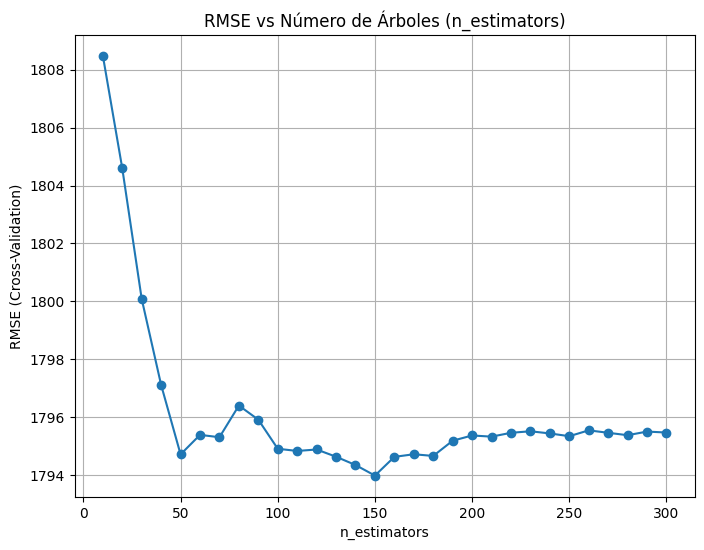

In [97]:

# Gráfica del RMSE vs n_estimators
plt.figure(figsize=(8, 6))
plt.plot(estimator_range, rmse_scores, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('RMSE (Cross-Validation)')
plt.title('RMSE vs Número de Árboles (n_estimators)')
plt.grid(True)
plt.show()


In [98]:

# --- Calibración de max_depth ---
# Creación de lista de valores para iterar sobre diferentes valores de max_depth
depth_range = range(1, len(feature_cols) + 1)

# Lista para almacenar el RMSE promedio para cada valor de max_depth
rmse_scores = []

# Uso de 5-fold cross-validation para cada valor de max_depth
for depth in depth_range:
    rf = RandomForestRegressor(n_estimators=150, max_depth=depth, random_state=42, n_jobs=-1)
    mse_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores.append(np.sqrt(-mse_scores.mean()))


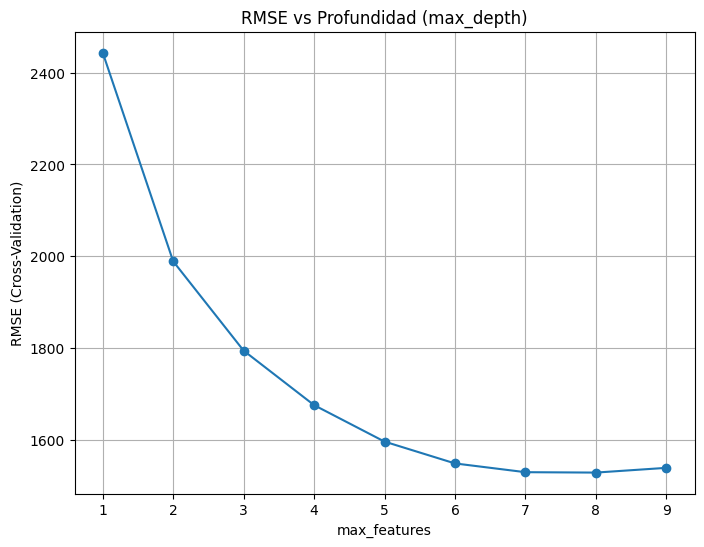

In [99]:

# Gráfica del RMSE vs max_depth
plt.figure(figsize=(8, 6))
plt.plot(depth_range, rmse_scores, marker='o')
plt.xlabel('max_features')
plt.ylabel('RMSE (Cross-Validation)')
plt.title('RMSE vs Profundidad (max_depth)')
plt.grid(True)
plt.show()

In [100]:

# --- Calibración de max_features ---
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, len(feature_cols) + 1)

# Lista para almacenar el RMSE promedio para cada valor de max_features
rmse_scores = []

# Uso de 5-fold cross-validation para cada valor de max_features
for feature in feature_range:
    rf = RandomForestRegressor(n_estimators=150, max_depth=8, max_features=feature, random_state=42, n_jobs=-1)
    mse_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores.append(np.sqrt(-mse_scores.mean()))


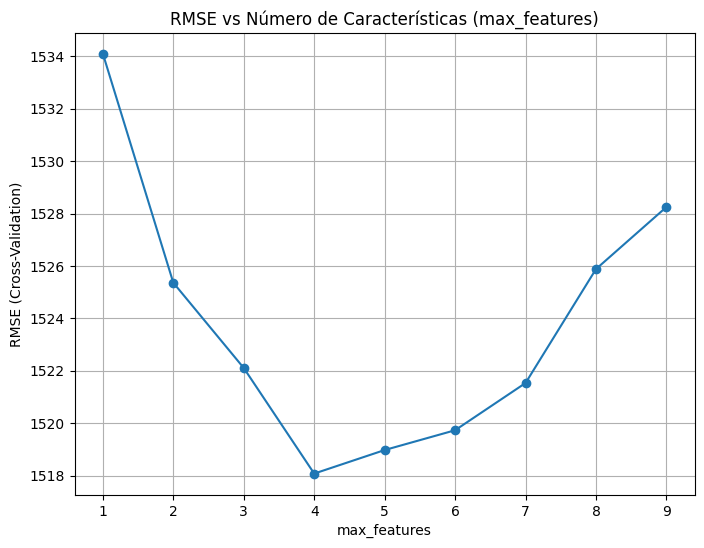

In [101]:

# Gráfica del RMSE vs max_features
plt.figure(figsize=(8, 6))
plt.plot(feature_range, rmse_scores, marker='o')
plt.xlabel('max_features')
plt.ylabel('RMSE (Cross-Validation)')
plt.title('RMSE vs Número de Características (max_features)')
plt.grid(True)
plt.show()

In [102]:
rf_model = RandomForestRegressor(
    n_estimators=150,        
    max_depth=8,
    max_features=4,                        
    random_state=42          
)

# Entrenamos el modelo
rf_model.fit(X_train, y_train)

# Hacemos predicciones en el conjunto de test
y_pred_rf = rf_model.predict(X_test)

# Calculamos RMSE y MAE
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

# Imprimimos los resultados
print(f"RMSE en el conjunto de test (Random Forest): {rmse_rf}")
print(f"MAE en el conjunto de test (Random Forest): {mae_rf}")

RMSE en el conjunto de test (Random Forest): 1552.389973600653
MAE en el conjunto de test (Random Forest): 1140.1629870853565


#### Análisis de calibración
Hay una caída muy rápida del RMSE al calibrar el número de estimadores (n_estimators) entre 10 y 50 sube un poco entre 50 y 80 para luego tocar el mínimo en 150 y después sube un poco y se estabiliza.

Al calibrar la profundidad máxima de cada árbol se ve que hay una caída continua del RMSE alcanzando el mínimo en 8. Por lo tanto se selecciona ese parámetro para el random forest.

Al calibrar la cantidad máxima de características que cada árbol debe tener en cuenta encontramos que la gráfica describe una especie de parábola o V y que el valor para max_features en el que el RMSE es mínimo es 4.

Al correr el modelo nuevamente con los parámetros óptimos vemos que hay una mejora considerable en el desempeño de las predicciones. El RMSE es ahora de 1552.39 y el MAE es ya de 1140.16 lo que evidencia una mejora muy significativa.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [103]:
# Celda 6
# Importamos las librerías necesarias
import xgboost as xgb

# Creamos el modelo de XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=10,         # Número de árboles
    max_depth=3,             # Profundidad máxima
    learning_rate=0.1,       # Tasa de aprendizaje (controla el aporte de cada árbol)
    random_state=42          # Para reproducibilidad
)

# Entrenamos el modelo
xgb_model.fit(X_train, y_train)

# Hacemos predicciones en el conjunto de test
y_pred_xgb = xgb_model.predict(X_test)

# Calculamos RMSE y MAE
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

# Imprimimos los resultados
print(f"RMSE en el conjunto de test (XGBoost): {rmse_xgb}")
print(f"MAE en el conjunto de test (XGBoost): {mae_xgb}")

RMSE en el conjunto de test (XGBoost): 2154.52419341255
MAE en el conjunto de test (XGBoost): 1657.5721435546875


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [104]:
# Celda 7
rmse_scores = []

# Uso de 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    xgb_model = xgb.XGBRegressor(n_estimators=estimator, max_depth=3, learning_rate=0.1, random_state=42)
    mse_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores.append(np.sqrt(-mse_scores.mean()))

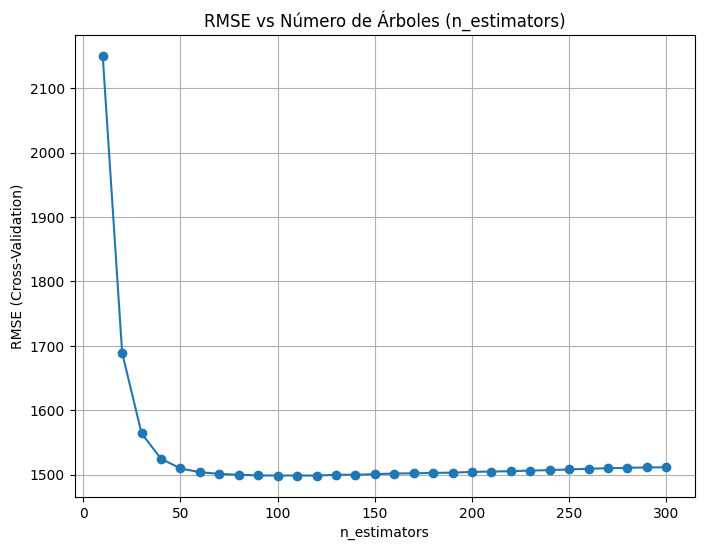

In [105]:
# Gráfica del RMSE vs n_estimators
plt.figure(figsize=(8, 6))
plt.plot(estimator_range, rmse_scores, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('RMSE (Cross-Validation)')
plt.title('RMSE vs Número de Árboles (n_estimators)')
plt.grid(True)
plt.show()

In [106]:
# Creación de lista de valores para iterar sobre diferentes valores de max_depth
depth_range = range(1, 11)

# Lista para almacenar el RMSE promedio para cada valor de max_depth
rmse_scores = []

# Uso de 5-fold cross-validation para cada valor de max_depth
for depth in depth_range:
    xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=depth, learning_rate=0.1, random_state=42)
    mse_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores.append(np.sqrt(-mse_scores.mean()))


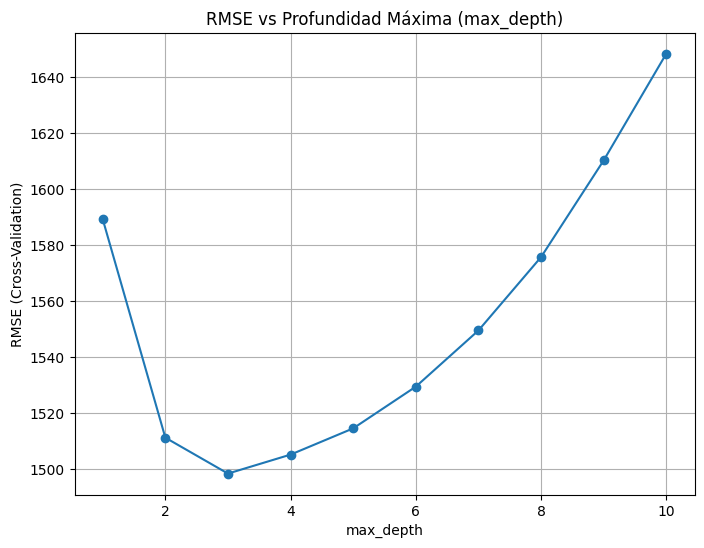

In [107]:

# Gráfica del RMSE vs max_depth
plt.figure(figsize=(8, 6))
plt.plot(depth_range, rmse_scores, marker='o')
plt.xlabel('max_depth')
plt.ylabel('RMSE (Cross-Validation)')
plt.title('RMSE vs Profundidad Máxima (max_depth)')
plt.grid(True)
plt.show()

In [108]:
# Creación de lista de valores para iterar sobre diferentes valores de learning_rate
learning_rate_range = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]

# Lista para almacenar el RMSE promedio para cada valor de learning_rate
rmse_scores = []

# Uso de 5-fold cross-validation para cada valor de learning_rate
for lr in learning_rate_range:
    xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=lr, random_state=42)
    mse_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores.append(np.sqrt(-mse_scores.mean()))


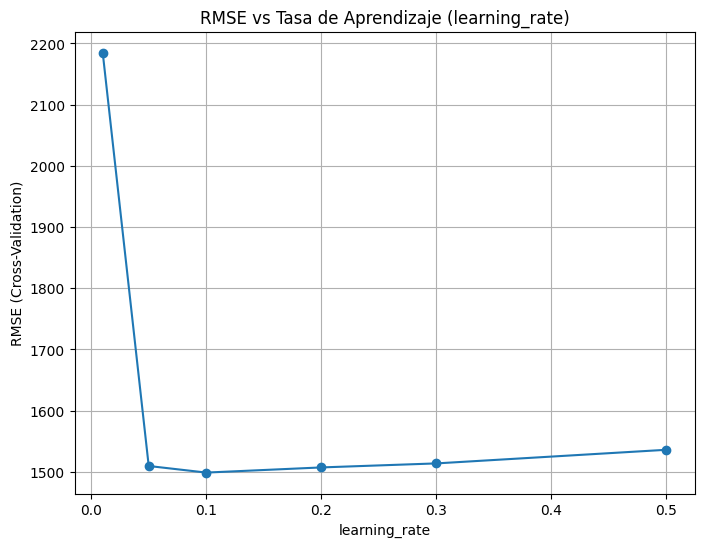

In [109]:

# Gráfica del RMSE vs learning_rate
plt.figure(figsize=(8, 6))
plt.plot(learning_rate_range, rmse_scores, marker='o')
plt.xlabel('learning_rate')
plt.ylabel('RMSE (Cross-Validation)')
plt.title('RMSE vs Tasa de Aprendizaje (learning_rate)')
plt.grid(True)
plt.show()

In [110]:
xgb_model = xgb.XGBRegressor(
    n_estimators=100,         # Número de árboles
    max_depth=3,             # Profundidad máxima
    learning_rate=0.1,       # Tasa de aprendizaje (controla el aporte de cada árbol)
    random_state=42          # Para reproducibilidad
)

# Entrenamos el modelo
xgb_model.fit(X_train, y_train)

# Hacemos predicciones en el conjunto de test
y_pred_xgb = xgb_model.predict(X_test)

# Calculamos RMSE y MAE
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

# Imprimimos los resultados
print(f"RMSE en el conjunto de test (XGBoost): {rmse_xgb}")
print(f"MAE en el conjunto de test (XGBoost): {mae_xgb}")

RMSE en el conjunto de test (XGBoost): 1538.1981341816795
MAE en el conjunto de test (XGBoost): 1127.329833984375


La calibración en el modelo XGBoost únicamente cambió el valor ede n_estimators. Sin embargo, ese único cambio hizo que las medidas de error mejoraran significativamente. El número de árboles a tener en cuenta para el modelo quedó en 100 y ese cambio hizo que el RMSE pasara de 2154.52 a 1538.2 y que el MAE pasara de 1657.57 a 1127.33

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

### Celda 8
Tras calibrar ambos modelos, los resultados muestran que XGBoost supera a Random Forest en precisión. XGBoost obtuvo un RMSE de 1538.20 y un MAE de 1127.33, mientras que Random Forest registró un RMSE de 1552.39 y un MAE de 1140.16. Aunque la diferencia es moderada, XGBoost demuestra un mejor desempeño en la predicción de precios.

Ventajas de XGBoost (el modelo superior): Destaca por su mayor precisión y su enfoque de boosting, que corrige errores de manera secuencial, permitiendo capturar relaciones complejas en los datos. Además, su flexibilidad en la configuración de parámetros, como la tasa de aprendizaje, facilita una optimización más precisa.

Desventajas de Random Forest (el de menor rendimiento): Aunque Random Forest ofrece resultados aceptables, su enfoque de promediar árboles independientes limita su capacidad para igualar la precisión de XGBoost, que aprende iterativamente. Asimismo, puede requerir mayor esfuerzo computacional con un número elevado de árboles y no siempre explota a fondo las interacciones más sutiles de los datos.

En conclusión, XGBoost se posiciona como la mejor opción en este caso, gracias a su superior rendimiento y adaptabilidad, superando a Random Forest por un margen pequeño.